<a href="https://colab.research.google.com/github/boxfather78/MaV/blob/main/MaV_Summative_Assessment_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <font color='Orange'> Modelling & Visualisation - Summative Assessment </font> 

---
This Colab workbook is split into 6 parts as follows:
- **Part 1**: imports, cleans and prepares card transaction data for analysis
- **Part 2**: exploratory data analysis with data visualisations
- **Part 3**: Model feature engineering
- **Part 4**: Creation of a series of analytical models to classify whether a card transaction is potentially fraudulent, alongside analysis of the benefits of each type of model
- **Part 5**:  An evaluation of the outcomes for each model using the test (and if applicable) validation datasets, and the creation of a table to store accuracy metrics
- **Part 6**: Illustrations showing the analytical outputs in an engaging manner.

[The GitHub repository can be found here:](https://github.com/boxfather78/MaV)

# <font color='Orange'> 1: Data Import, initial EDA and cleansing </font>

### 1.1: Import code libraries and CSV
Pandas and Numpy data libraries support reading in and wrangling datasets. Import dataframe formatter for easier viewing. 
Pick up transaction dataset and read into Pandas dataframe; sort by Transaction ID. [see pipeline preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)

In [130]:
import pandas as pd
import numpy as np

from google.colab import data_table
data_table.enable_dataframe_formatter()

df1 = pd.read_csv('https://raw.githubusercontent.com/boxfather78/MaV/main/CreditCardDataFinal.csv')
print(df1.shape)
df1.sort_values(["Transaction ID"], ascending=True).head()

(100000, 16)


Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
25167      #2546 884  13-Oct-20     Tuesday    23   MasterCard        CVC   
74516      #2546 895  14-Oct-20   Wednesday    21         Visa        CVC   
57940      #2546 903  13-Oct-20     Tuesday    19         Visa        CVC   
9776       #2546 906  14-Oct-20   Wednesday     9   MasterCard        PIN   
52568      #2546 920  13-Oct-20     Tuesday    22         Visa        CVC   

      Amount Type of Transaction Merchant Group Country of Transaction  \
25167    £17              Online     Restaurant         United Kingdom   
74516    £28              Online         Gaming         United Kingdom   
57940     £8              Online   Subscription         United Kingdom   
9776    £186                 ATM  Entertainment         United Kingdom   
52568    £86              Online       Children         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  
25167           Russia       United Kingdom      F  60.5  Barclays      0  
74516   United Kingdom       United Kingdom      M  49.7       RBS      0  
57940   United Kingdom       United Kingdom      M  46.2  Barclays      0  
9776    United Kingdom       United Kingdom      F  51.3  Barclays      0  
52568   United Kingdom       United Kingdom      F  59.6     Monzo      0

### 1.2: Split dataset
Split dataset into test/train datasets, saving copies of each. This should be done before significant Exploratory Data Analysis or pre-processing, to avoid data (and therefore knowledge) from the test cell influencing both EDA and pre-processing (citation).

In [131]:
# Split dataset into predictor/target datasets.
from sklearn.model_selection import train_test_split
x = df1.drop(["Fraud"], axis=1)
print("Predictor Dataset contains:", x.columns)
y = pd.DataFrame(df1["Fraud"])
print("Target Dataset contains:", y.columns)

# Create model training and test splits. As we have class imbalance in the model, we will stratify samples.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42, stratify=y)
print("x-train:", x_train.shape)
print("y-train:", y_train.shape)
print("x-test:", x_test.shape)
print("y-test:", y_test.shape)

# Merge together training, test and validation datasets to validate stratification.
df1_train = pd.concat([x_train, y_train], axis=1)
print("df1_train:",df1_train.shape)
df1_test = pd.concat([x_test, y_test], axis=1)
print("df1_test:",df1_test.shape,"\n")

fraud_rate_train = pd.crosstab(index=df1_train["Fraud"], columns="Percent", values=df1_train.index, aggfunc='count', normalize='columns').round(4)*100
fraud_rate_test = pd.crosstab(index=df1_test["Fraud"], columns="Percent", values=df1_test.index, aggfunc='count', normalize='columns').round(4)*100

print("Train Fraud Rate \n", fraud_rate_train, "\n Test Fraud Rate \n", fraud_rate_test)

Predictor Dataset contains: Index(['Transaction ID', 'Date', 'Day of Week', 'Time', 'Type of Card',
       'Entry Mode', 'Amount', 'Type of Transaction', 'Merchant Group',
       'Country of Transaction', 'Shipping Address', 'Country of Residence',
       'Gender', 'Age', 'Bank'],
      dtype='object')
Target Dataset contains: Index(['Fraud'], dtype='object')
x-train: (80000, 15)
y-train: (80000, 1)
x-test: (20000, 15)
y-test: (20000, 1)
df1_train: (80000, 16)
df1_test: (20000, 16) 

Train Fraud Rate 
 col_0  Percent
Fraud         
0         92.8
1          7.2 
 Test Fraud Rate 
 col_0  Percent
Fraud         
0         92.8
1          7.2


### 1.3: Profile Report
Install latest version of pandas profiling; import Profile Report and create a report to explore the dataset.

In [132]:
# Install latest version of Pandas Profiling
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

from pandas_profiling import ProfileReport

# Create profile report, save and view
prof = ProfileReport(df1_train)
prof.to_file(output_file='output.html')
prof

  Using cached https://github.com/ydataai/pandas-profiling/archive/master.zip


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.4: Check for DUPLICATES
From the profile report, we can see there are duplicates in the Transaction ID variable, which we might have considered a primary key. There are no full duplicates. Let's look at the Txn ID duplicates to validate treatment.

In [133]:
# Add column to validate full column-wise duplication and another column for Transaction ID duplicates
df1_train['Full_duplicate'] = df1_train.duplicated(keep='first')
df1_train['TxnID_duplicate'] = df1_train["Transaction ID"].duplicated(keep='first')

# Create dataframe of duplicates and count Txn IDs
df1_full_dupe = df1_train[(df1_train['Full_duplicate'] == True)]
df1_dupe = df1_train[(df1_train['TxnID_duplicate'] == True)]
print("There are", len(df1_full_dupe), " full duplicates across the file.") # 0 duplicates in file
print("There are", len(df1_dupe), "duplicates in the Transaction ID column") # 2,773 duplicates by Transaction ID in file

There are 0  full duplicates across the file.
There are 2773 duplicates in the Transaction ID column


1.4.1: Explore the Transaction ID duplicates

In [134]:
# Create list of Transaction ID duplicates
dupe_list = df1_dupe["Transaction ID"].tolist()

# Create dataframe of first 5 duplicate Txn IDs and the most frequently occurring Txn ID as shown by profile report, then view all matching records
df1_dupesamp = df1_train[df1_train["Transaction ID"].isin(dupe_list[0:4])]
df2_dupesamp = df1_train[df1_train["Transaction ID"] == "#2617 708"]
df3_dupesamp = df1_dupesamp.append(df2_dupesamp).sort_values(["Transaction ID"], ascending=True) 
df3_dupesamp

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
40884      #2617 708  13-Oct-20     Tuesday    13         Visa        CVC   
44182      #2617 708  13-Oct-20     Tuesday    18   MasterCard        CVC   
31680      #2617 708  13-Oct-20     Tuesday    23   MasterCard        CVC   
34877      #2617 708  13-Oct-20     Tuesday    22   MasterCard        CVC   
43633      #2775 342  13-Oct-20     Tuesday    11   MasterCard        PIN   
52077      #2775 342  13-Oct-20     Tuesday    10   MasterCard        CVC   
93561      #3365 909  14-Oct-20   Wednesday    19   MasterCard        CVC   
77610      #3365 909  14-Oct-20   Wednesday    18         Visa        CVC   
20344      #3457 714  13-Oct-20     Tuesday    19         Visa        Tap   
42290      #3457 714  14-Oct-20   Wednesday    12         Visa        CVC   
31638      #3684 586  14-Oct-20   Wednesday     8   MasterCard        Tap   
45763      #3684 586  14-Oct-20   Wednesday    18   MasterCard        CVC   

      Amount Type of Transaction Merchant Group Country of Transaction  \
40884    £10              Online   Subscription         United Kingdom   
44182    £22              Online       Services                 Russia   
31680   £183              Online   Subscription         United Kingdom   
34877   £206              Online           Food         United Kingdom   
43633    £30                 ATM     Restaurant                    USA   
52077    £27              Online       Services                 Russia   
93561    £76              Online         Gaming         United Kingdom   
77610    £22              Online   Subscription         United Kingdom   
20344    £23                 POS    Electronics         United Kingdom   
42290   £353              Online       Children         United Kingdom   
31638    £14                 POS     Restaurant         United Kingdom   
45763    £14              Online           Food                    USA   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
40884   United Kingdom       United Kingdom      M  53.9   Halifax      0   
44182           Russia               Russia      M  56.4   Halifax      0   
31680   United Kingdom       United Kingdom      F  48.1   Halifax      0   
34877            China       United Kingdom      M  45.6    Lloyds      0   
43633              USA                  USA      F  43.4  Barlcays      0   
52077           Russia               Russia      F  52.3     Metro      0   
93561   United Kingdom       United Kingdom      M  65.6      HSBC      0   
77610   United Kingdom       United Kingdom      F  56.1     Monzo      0   
20344   United Kingdom       United Kingdom      F  46.4     Metro      0   
42290   United Kingdom       United Kingdom      M  44.2   Halifax      0   
31638   United Kingdom       United Kingdom      F  40.5      HSBC      0   
45763              USA                  USA      F  34.6  Barclays      0   

       Full_duplicate  TxnID_duplicate  
40884           False            False  
44182           False             True  
31680           False             True  
34877           False             True  
43633           False            False  
52077           False             True  
93561           False            False  
77610           False             True  
20344           False            False  
42290           False             True  
31638           False            False  
45763           False             True

1.4.2: Confirmation that duplicate Transaction IDs don't look like duplicate transactions, but could duplicates point to fraud?

In [135]:
# Is a duplicate transaction ID an indicator of Fraud?
fraud_dupe = pd.crosstab(index=df1_dupe["Fraud"], columns="Percent", normalize = "columns").round(4)*100
fraud_rate = pd.crosstab(index=df1_train["Fraud"], columns="Percent", normalize = "columns").round(4)*100
print(fraud_dupe, "\n", fraud_rate)
# Positive fraud rate of duplicates is 7.9% vs. full file rate of 7.2%, so might be worth creating a marker against all duplicated Txn_IDs.

col_0  Percent
Fraud         
0         92.1
1          7.9 
 col_0  Percent
Fraud         
0         92.8
1          7.2


1.4.3: Create new variable indicating that Txn ID is a duplicate

In [136]:
# Create duplicate Transaction ID indicator
df1_train["TxnID_Dup"] = np.where(df1_train["Transaction ID"].isin(dupe_list), 1, 0)

# Drop Full_Duplicate and Txn_ID Duplicate variables from df1_train
df1_train.drop(["Full_duplicate","TxnID_duplicate"], axis=1, inplace=True)
df1_train.head()

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
74551      #3175 659  13-Oct-20     Tuesday     7         Visa        PIN   
63789      #2913 418  13-Oct-20     Tuesday    20   MasterCard        PIN   
73905      #3370 828  14-Oct-20   Wednesday    18   MasterCard        Tap   
27944      #3639 312  13-Oct-20     Tuesday     7         Visa        Tap   
49155      #3594 542  13-Oct-20     Tuesday    13   MasterCard        PIN   

      Amount Type of Transaction Merchant Group Country of Transaction  \
74551    £69                 ATM       Children                 Russia   
63789   £295                 POS        Fashion         United Kingdom   
73905     £9                 POS     Restaurant         United Kingdom   
27944     £7                 POS       Products         United Kingdom   
49155   £356                 ATM       Products         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
74551           Russia       United Kingdom      M  40.6    Lloyds      0   
63789   United Kingdom       United Kingdom      F  38.7   Halifax      0   
73905   United Kingdom       United Kingdom      M  54.0      HSBC      0   
27944   United Kingdom       United Kingdom      F  42.0       RBS      0   
49155   United Kingdom       United Kingdom      M  28.0  Barlcays      0   

       TxnID_Dup  
74551          0  
63789          0  
73905          0  
27944          0  
49155          0

### 1.5: Check for COMPLETENESS
 Check for completeness and missing values

In [137]:
# We can see missing values in the dataset from the profile report. This is validated here.
print("There are",sum(df1_train.isnull().any(axis=1)),"rows with at least one missing value")
# Validate which columns have missing values
print(df1_train.isna().sum());

There are 16 rows with at least one missing value
Transaction ID            0
Date                      0
Day of Week               0
Time                      0
Type of Card              0
Entry Mode                0
Amount                    5
Type of Transaction       0
Merchant Group            7
Country of Transaction    0
Shipping Address          2
Country of Residence      0
Gender                    3
Age                       0
Bank                      0
Fraud                     0
TxnID_Dup                 0
dtype: int64


In [138]:
# Create dataframe of missing values then check fraud rates across dataset
null_data = df1_train[df1_train.isnull().any(axis=1)]
fraud_null = pd.crosstab(index=null_data["Fraud"], columns="Percent", normalize = "columns").round(4)*100
print(fraud_null)

# Fraud rate is 12.5% where a value is missing, versus 7.2% on full file, meaning transaction is more likely to be fraud if at least one value is missing.

col_0  Percent
Fraud         
0         87.5
1         12.5


In [139]:
# We can also look at Fraud rate against missing values in specific columns
null_data_amount = df1_train[df1_train["Amount"].isnull()]
fraud_null_amount = pd.crosstab(index=null_data_amount["Fraud"], columns="Percent", normalize = "columns").round(4)*100
null_data_merchant = df1_train[df1_train["Merchant Group"].isnull()]
fraud_null_merchant = pd.crosstab(index=null_data_merchant["Fraud"], columns="Percent", normalize = "columns").round(4)*100
null_data_shipping = df1_train[df1_train["Shipping Address"].isnull()]
fraud_null_shipping = pd.crosstab(index=null_data_shipping["Fraud"], columns="Percent", normalize = "columns").round(4)*100
null_data_gender = df1_train[df1_train["Gender"].isnull()]
fraud_null_gender = pd.crosstab(index=null_data_gender["Fraud"], columns="Percent", normalize = "columns").round(4)*100
print("Amount\n", fraud_null_amount,"\n\n", "Merchant Group\n", fraud_null_merchant,"\n\n", "Shipping Address\n",
      fraud_null_shipping,"\n\n", "Gender\n", fraud_null_gender)

# Fraud is present across 40% of cases where Amount is null. 

Amount
 col_0  Percent
Fraud         
0         60.0
1         40.0 

 Merchant Group
 col_0  Percent
Fraud         
0        100.0 

 Shipping Address
 col_0  Percent
Fraud         
0        100.0 

 Gender
 col_0  Percent
Fraud         
0        100.0


1.5.1: Null value treatments 

* Taking an average value could be one option for in-fill of the missing values for Amount, but this could skew the outcome, since 40% are fraudulent. Zero is another option, as is removal. We'll come back to this after converting the variable to a numeric and running descriptive statistics.
* It's not possible to impute Merchant Group or Shipping Address accurately by using other information. Since this is a categorical variable, we could just label these as unknown, but as the volume of missing is low we will remove.
* Missing gender cannot be imputed accurately without more information such as customer name and missing volume is low so we will drop these rows.

In [140]:
# Deal with nulls as shown above - remove rows with missing Genders, Merchant Groups and Shipping Address
df1_train.dropna(how='any', subset=['Gender','Merchant Group','Shipping Address'], inplace=True)

print(df1_train.shape) # 11 records removed
df1_train.head()

(79989, 17)


Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
74551      #3175 659  13-Oct-20     Tuesday     7         Visa        PIN   
63789      #2913 418  13-Oct-20     Tuesday    20   MasterCard        PIN   
73905      #3370 828  14-Oct-20   Wednesday    18   MasterCard        Tap   
27944      #3639 312  13-Oct-20     Tuesday     7         Visa        Tap   
49155      #3594 542  13-Oct-20     Tuesday    13   MasterCard        PIN   

      Amount Type of Transaction Merchant Group Country of Transaction  \
74551    £69                 ATM       Children                 Russia   
63789   £295                 POS        Fashion         United Kingdom   
73905     £9                 POS     Restaurant         United Kingdom   
27944     £7                 POS       Products         United Kingdom   
49155   £356                 ATM       Products         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
74551           Russia       United Kingdom      M  40.6    Lloyds      0   
63789   United Kingdom       United Kingdom      F  38.7   Halifax      0   
73905   United Kingdom       United Kingdom      M  54.0      HSBC      0   
27944   United Kingdom       United Kingdom      F  42.0       RBS      0   
49155   United Kingdom       United Kingdom      M  28.0  Barlcays      0   

       TxnID_Dup  
74551          0  
63789          0  
73905          0  
27944          0  
49155          0

### 1.6: Check for CONFORMITY
Based on review of data types, recommended actions are:
* Convert 'Date' to DateTime variable, to support a potential wider dataset in future and/or time series analysis.
* Convert 'Day of Week', 'Type of Card', 'Entry Mode', 'Type of Transaction','Merchant Group','Country of Transaction','Shipping Address','Country of Residence','Bank' into Category variables to make variable contents clear.
* 'Amount' should be a float variable, but here it is rounded to a whole number as an object. To convert, we will first remove currency symbol, as all are in GBP.
* While we could change 'Time' to a DateTime variable as well, It is simple enough to interpret as an integer, so I will leave as is.

In [141]:
print(df1_train.dtypes)

Transaction ID             object
Date                       object
Day of Week                object
Time                        int64
Type of Card               object
Entry Mode                 object
Amount                     object
Type of Transaction        object
Merchant Group             object
Country of Transaction     object
Shipping Address           object
Country of Residence       object
Gender                     object
Age                       float64
Bank                       object
Fraud                       int64
TxnID_Dup                   int64
dtype: object


In [142]:
# Replace £ signs and convert Amount to a float
df1_train["Amount"] = df1_train["Amount"].replace('£', '', regex=True)
df1_train = df1_train.astype({"Amount": 'float'})
# Convert Object variables into Categorical
df1_train = df1_train.astype({"Day of Week": 'category',"Type of Card": 'category',"Entry Mode":'category',"Type of Transaction":'category',
                  "Merchant Group":'category',"Country of Transaction":'category',"Shipping Address":'category',
                  "Country of Residence":'category',"Bank":'category',"Gender":'category'})

# Convert Date into Datetime variable
df1_train["Date"] = pd.to_datetime(df1_train["Date"])
print(df1_train.dtypes)

Transaction ID                    object
Date                      datetime64[ns]
Day of Week                     category
Time                               int64
Type of Card                    category
Entry Mode                      category
Amount                           float64
Type of Transaction             category
Merchant Group                  category
Country of Transaction          category
Shipping Address                category
Country of Residence            category
Gender                          category
Age                              float64
Bank                            category
Fraud                              int64
TxnID_Dup                          int64
dtype: object


In [143]:
# Validate changes by exploring start of file
df1_train.head()

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
74551      #3175 659 2020-10-13     Tuesday     7         Visa        PIN   
63789      #2913 418 2020-10-13     Tuesday    20   MasterCard        PIN   
73905      #3370 828 2020-10-14   Wednesday    18   MasterCard        Tap   
27944      #3639 312 2020-10-13     Tuesday     7         Visa        Tap   
49155      #3594 542 2020-10-13     Tuesday    13   MasterCard        PIN   

       Amount Type of Transaction Merchant Group Country of Transaction  \
74551    69.0                 ATM       Children                 Russia   
63789   295.0                 POS        Fashion         United Kingdom   
73905     9.0                 POS     Restaurant         United Kingdom   
27944     7.0                 POS       Products         United Kingdom   
49155   356.0                 ATM       Products         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
74551           Russia       United Kingdom      M  40.6    Lloyds      0   
63789   United Kingdom       United Kingdom      F  38.7   Halifax      0   
73905   United Kingdom       United Kingdom      M  54.0      HSBC      0   
27944   United Kingdom       United Kingdom      F  42.0       RBS      0   
49155   United Kingdom       United Kingdom      M  28.0  Barlcays      0   

       TxnID_Dup  
74551          0  
63789          0  
73905          0  
27944          0  
49155          0

### 1.7: Check for INTEGRITY
Checking for erroneous values



In [144]:
# Rerun profile report on updated dataset
prof2 = ProfileReport(df1_train)
prof2.to_file(output_file='output2.html')
prof2

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

1.7.1 Data Integrity Observations:
* Date has some values that fall outside 13/14th October - validate and possibly remove
* Time has 25 distinct values, yet there are only 24 hours in the day - validate whether we should merge 0 and 24.
* Amount has a minimum value of 5, meaning we shouldn't lose information by imputing NaNs as 0.
* Age contains values under 18 - under 18s can't hold credit cards in the UK - analysis needed on these records (citation)
* Day of Week contains errors - we should only have Tuesday and Wednesday - validate and correct
* Bank contains possible type 'Barlcays' - validate and correct.

In [145]:
# VALIDATIONS
# Date - check any issue with removing 2 records from 15/16th October to maintain date integrity
date_check = df1_train.groupby(['Date', 'Fraud'])['Fraud'].count().rename("count")
print("Fraud rate by date: \n", date_check,"\n") 

# Time - view records to understand treatment for 1 value of 24
datetime_check = df1_train[df1_train["Time"] == 24]
print("Records with Time of 24: \n", datetime_check, '\n') # Case is fraudulent, suggest relabelling as 0 to indicate midnight.

# Age - create variable for U18s to view if the Fraud profile is different or whether country of residence might permit u18 to hold credit card
df1_train["Age_lt18"] = np.where(df1_train["Age"] < 18, 'Yes', 'No')
age_check = df1_train.groupby(['Age_lt18', 'Fraud'])['Fraud'].count().rename("count")
age_loc_check = df1_train.groupby(['Country of Residence', 'Age_lt18'])['Fraud'].count().rename("count")
print("Fraud rate by Age of <18: \n", age_check / age_check.groupby(level=0).sum()*100, '\n') # Marginally higher rates of fraud amongst under 18s
print("Country of Residence by Age of <18: \n", age_loc_check, '\n') # Most u18s are indeed in UK 

# Bank - check Fraud rate of 'Barlcays' vs. other banks
bank_check = df1_train.groupby(['Bank', 'Fraud'])['Fraud'].count().rename("count")
print("Fraud rate by bank name: \n", bank_check / bank_check.groupby(level=0).sum()*100,'\n') # A lower rate of Fraud, but clearly a typo that needs correcting

# Day of Week - create unique list of days then create dataframe of values with DoW = Thursday or Friday
dow_list = df1_train["Day of Week"].tolist()
dow_unique = pd.unique(dow_list)
print("Unique list of days:", dow_unique,"\n")
dow_check = df1_train[df1_train["Day of Week"].isin(dow_unique[2:])]
print("All records with Day of week = Thursday or Friday:")
dow_check

Fraud rate by date: 
 Date        Fraud
2020-10-13  0        36853
            1         2994
2020-10-14  0        37380
            1         2760
2020-10-15  1            1
2020-10-16  1            1
Name: count, dtype: int64 

Records with Time of 24: 
       Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
32446      #2547 017 2020-10-14   Wednesday    24   MasterCard        CVC   

       Amount Type of Transaction Merchant Group Country of Transaction  \
32446   371.0              Online    Electronics                  India   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
32446            India                India      M  57.7  Barclays      1   

       TxnID_Dup  
32446          1   

Fraud rate by Age of <18: 
 Age_lt18  Fraud
No        0        92.804458
          1         7.195542
Yes       0        92.537313
          1         7.462687
Name: count, dtype: float64 

Country of Residence by Age of <18: 
 Country of Res

Transaction ID       Date Day of Week  Time Type of Card Entry Mode  \
75994      #3271 352 2020-10-13    Thursday    16         Visa        Tap   
96801      #2686 124 2020-10-13      Friday     9         Visa        CVC   
20296      #3066 613 2020-10-13    Thursday    10         Visa        PIN   
48256      #2872 483 2020-10-14      Friday    11   MasterCard        CVC   
64255      #2548 251 2020-10-15    Thursday     8         Visa        PIN   
37546      #2870 052 2020-10-13    Thursday    13   MasterCard        Tap   
68093      #2983 032 2020-10-14      Friday    15         Visa        CVC   
64778      #3328 717 2020-10-14    Thursday    16   MasterCard        Tap   
10483      #2982 416 2020-10-13    Thursday     7         Visa        PIN   
30844      #2895 855 2020-10-13      Friday     7         Visa        CVC   
86631      #3533 700 2020-10-13      Friday    12         Visa        CVC   
61677      #2548 251 2020-10-16      Friday     8         Visa        PIN   
904        #3314 299 2020-10-14    Thursday     7   MasterCard        Tap   
60678      #2921 986 2020-10-13      Friday    13   MasterCard        CVC   
9722       #3084 661 2020-10-13      Friday    11   MasterCard        PIN   
35327      #2683 600 2020-10-14      Friday    13         Visa        PIN   
63585      #3315 219 2020-10-14      Friday    11         Visa        PIN   
8421       #2997 386 2020-10-13      Friday    12   MasterCard        PIN   

       Amount Type of Transaction Merchant Group Country of Transaction  \
75994     7.0                 POS       Products                 Russia   
96801    21.0              Online        Fashion         United Kingdom   
20296   169.0                 POS        Fashion         United Kingdom   
48256   215.0              Online  Entertainment                    USA   
64255   243.0                 POS         Gaming         United Kingdom   
37546    28.0                 POS   Subscription                 Russia   
68093    16.0              Online    Electronics         United Kingdom   
64778    18.0                 POS       Services         United Kingdom   
10483   294.0                 ATM         Gaming         United Kingdom   
30844    25.0              Online        Fashion         United Kingdom   
86631    55.0              Online         Gaming                 Russia   
61677   243.0                 POS         Gaming         United Kingdom   
904      25.0                 POS         Gaming         United Kingdom   
60678   134.0              Online    Electronics         United Kingdom   
9722     13.0                 ATM       Services         United Kingdom   
35327    26.0                 ATM       Children         United Kingdom   
63585    37.0                 POS       Services                    USA   
8421    198.0                 POS         Gaming         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  \
75994           Russia       United Kingdom      F  61.1     Metro      1   
96801            India       United Kingdom      M  39.6      HSBC      0   
20296   United Kingdom       United Kingdom      M  48.6  Barclays      0   
48256              USA                  USA      F  38.7  Barclays      0   
64255   United Kingdom       United Kingdom      M  38.9  Barclays      1   
37546           Russia               Russia      F  57.6     Monzo      0   
68093   United Kingdom       United Kingdom      M  49.7   Halifax      0   
64778   United Kingdom       United Kingdom      M  41.5  Barclays      0   
10483   United Kingdom       United Kingdom      M  38.6  Barlcays      0   
30844   United Kingdom       United Kingdom      M  33.4     Monzo      0   
86631           Russia               Russia      M  44.7  Barlcays      0   
61677   United Kingdom       United Kingdom      M  38.6  Barclays      1   
904     United Kingdom       United Kingdom      M  31.2   Halifax      0   
60678   United Kingdom       United Ki

In [146]:
# DATA CLEANSE

# Amount - recode our 6 NaNs to 0 and check
df1_train["Amount"] = df1_train["Amount"].replace(np.nan, 0, regex=True)
print("Show new Min value of Amount variable \n", df1_train["Amount"].describe(),"\n") # Min value is now 0.

# Date - 15/16th Oct are both marked as Fraudulent, yet we can't impute a new date. Remove to maintain integrity of dataset which is only supposed to be 13/14th Oct transactions.
df1_train = df1_train.drop(df1_train[(df1_train["Date"] == "2020-10-15") | (df1_train["Date"] ==  "2020-10-16")].index)
date_check2 = df1_train.groupby(['Date','Day of Week'])['Date'].count().rename("count")
print("No more dates of 15/16th in Date column \n", date_check2, "\n") 
print("Two records removed: \n", len(df1_train),"\n") # 2 records removed; only 13/14th Oct remain.

# Time - replace singlevalue of 24 with 0
df1_train["Time"] = df1_train["Time"].replace(24, 0, regex=True)
new_time = df1_train.groupby(['Time'])['Time'].count().rename("count")
print("No more 24 in Time variable \n", new_time,"\n")

# Age - No treatment required, but we will remove the variable that was created for validation
df1_train.drop(["Age_lt18"], axis=1, inplace=True)

# Day of Week - Replace incorrect Days of Week to align with Date.
df1_train["Day of Week"] = np.where(df1_train["Date"] == "2020-10-13", "Tuesday", "Wednesday")
date_check3 = df1_train.groupby(['Date','Day of Week'])['Date'].count().rename("count")
print("No more Thursday/Friday in Day of Week column: \n", date_check3,"\n") # Only Tues/Wed now present in data, aligned to correct dates.

# Bank - Amend 'Barlcays' to 'Barclays'
df1_train["Bank"] = df1_train["Bank"].replace('Barlcays', 'Barclays', regex=True)
bank_check = df1_train.groupby(["Bank"])["Bank"].count().rename("count")
print("No more 'Barlcays' in data: \n", bank_check,"\n") # Barlcays no longer in data.

Show new Min value of Amount variable 
 count    79989.000000
mean       112.778007
std        123.634020
min          0.000000
25%         17.000000
50%         30.000000
75%        209.000000
max        400.000000
Name: Amount, dtype: float64 

No more dates of 15/16th in Date column 
 Date        Day of Week
2020-10-13  Friday             6
            Thursday           4
            Tuesday        39837
            Wednesday          0
2020-10-14  Friday             4
            Thursday           2
            Tuesday            0
            Wednesday      40134
Name: count, dtype: int64 

Two records removed: 
 79987 

No more 24 in Time variable 
 Time
0      407
1      389
2      422
3      432
4      390
5      377
6      402
7     4538
8     4540
9     4452
10    4513
11    4619
12    4593
13    4661
14    4589
15    4604
16    4622
17    4532
18    4470
19    4432
20    4404
21    4464
22    4531
23    4604
Name: count, dtype: int64 

No more Thursday/Friday in Day of Wee

### 1.8: Check for OUTLIERS




In [147]:
# Descriptives for numeric variables
print(df1_train.describe())

               Time        Amount           Age         Fraud     TxnID_Dup
count  79987.000000  79987.000000  79987.000000  79987.000000  79987.000000
mean      14.559316    112.774751     44.997558      0.071937      0.068649
std        5.302701    123.633851      9.954264      0.258385      0.252857
min        0.000000      0.000000     15.000000      0.000000      0.000000
25%       10.000000     17.000000     38.200000      0.000000      0.000000
50%       15.000000     30.000000     44.900000      0.000000      0.000000
75%       19.000000    209.000000     51.700000      0.000000      0.000000
max       23.000000    400.000000     86.100000      1.000000      1.000000


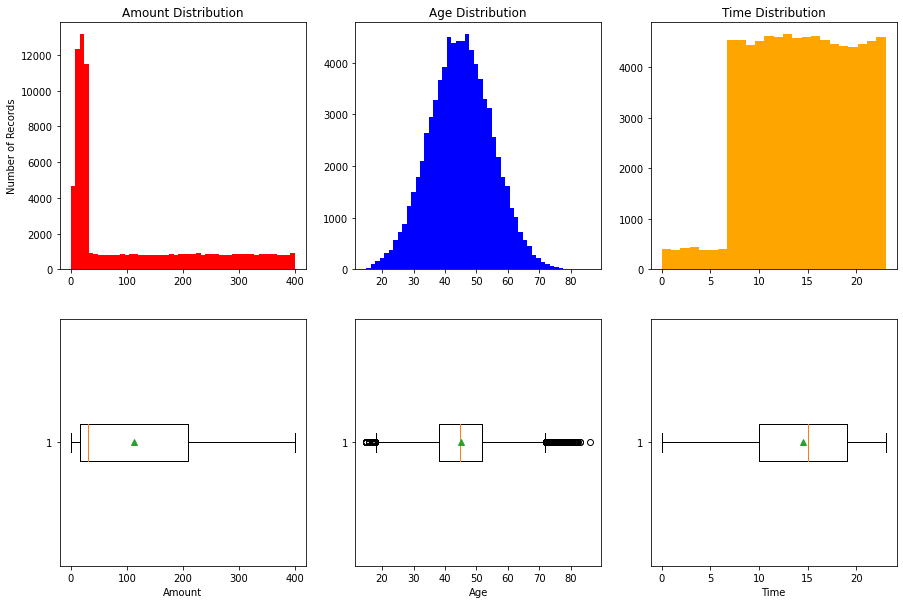

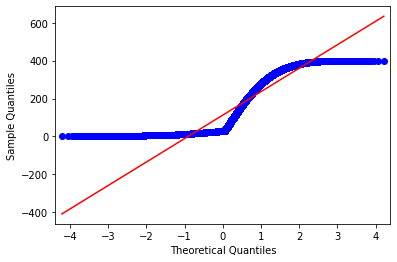

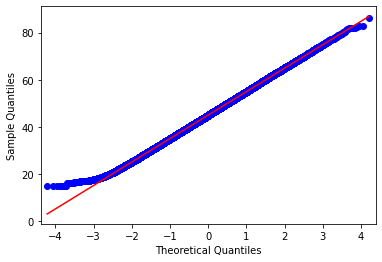

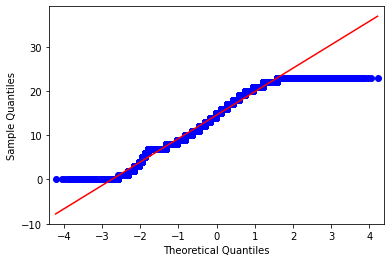

In [148]:
# OUTLIERS - Look at histograms for Time, Amount and Age.
import matplotlib.pyplot as plt #Import matplotlib to show some variable comparisons
%matplotlib inline

# Define series
x = df1_train["Amount"]
y = df1_train["Age"]
z = df1_train["Time"]

# Define canvas size and layout
fig, axs = plt.subplots(2, 3, figsize=(15,10))

# Top level for Histograms
axs[0,0].hist(x,bins=50,histtype='bar',color='red')
axs[0,0].set(title='Amount Distribution', ylabel='Number of Records')
axs[0,1].hist(y,bins=50,histtype='bar',color='blue')
axs[0,1].set(title='Age Distribution')
axs[0,2].hist(z,bins=24,histtype='bar',color='orange') # 24 bins to support hours in day
axs[0,2].set(title='Time Distribution')

# Bottom level for box-plots
axs[1,0].boxplot(x,showmeans=True, vert=False, notch=False)
axs[1,0].set(xlabel='Amount')
axs[1,1].boxplot(y,showmeans=True, vert=False, notch=False)
axs[1,1].set(xlabel='Age')
axs[1,2].boxplot(z,showmeans=True, vert=False, notch=False)
axs[1,2].set(xlabel='Time')

# Quartile-Quartile charts may show non-normal distribution effectively - perhaps remove
import statsmodels.api as sm
fig1 = sm.qqplot(df1_train["Amount"],line='s')
fig1 = sm.qqplot(df1_train["Age"],line='s')
fig1 = sm.qqplot(df1_train["Time"],line='s')

plt.show()

1.8.1: Numeric variable distribution/outlier observations:

Amount is right-skewed, Age has a normal distribution with some outliers, but these are not of concern, beyond what has already been discussed re: legal credit-card ownership in UK.Time is left-skewed, due to lower volume of transactions during night hours. 

### 1.9: Save cleansed train dataset for next step.

In [149]:
# Validate columns in df1 dataset
print(df1_train.columns)
# Save dataset while keeping original columns
df1_train.to_csv('CreditCardDataFinalClean.csv', mode='w', index=True)

# Download dataset for local copy
from google.colab import files
files.download('CreditCardDataFinalClean.csv')

Index(['Transaction ID', 'Date', 'Day of Week', 'Time', 'Type of Card',
       'Entry Mode', 'Amount', 'Type of Transaction', 'Merchant Group',
       'Country of Transaction', 'Shipping Address', 'Country of Residence',
       'Gender', 'Age', 'Bank', 'Fraud', 'TxnID_Dup'],
      dtype='object')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# <font color='Orange'> 2: Data Pre-processing and further EDA </font>

### 2.1: Re-run profile report
This time on our cleansed data

In [152]:
# Read in cleansed dataset, drop Transaction ID and set index
df2_train = pd.read_csv('https://raw.githubusercontent.com/boxfather78/MaV/main/CreditCardDataFinalClean.csv')
df2_train.set_index(df2_train.columns[0], drop=True, inplace=True)
df2_train.index.name = None
df2_train = df2_train.drop("Transaction ID", axis=1)
print(df2_train.head())
print(df2_train.dtypes)

# Rerun profile report on updated dataset
prof3 = ProfileReport(df2_train)
prof3.to_file(output_file='output3.html')
prof3

             Date Day of Week  Time Type of Card Entry Mode  Amount  \
74551  2020-10-13     Tuesday     7         Visa        PIN    69.0   
63789  2020-10-13     Tuesday    20   MasterCard        PIN   295.0   
73905  2020-10-14   Wednesday    18   MasterCard        Tap     9.0   
27944  2020-10-13     Tuesday     7         Visa        Tap     7.0   
49155  2020-10-13     Tuesday    13   MasterCard        PIN   356.0   

      Type of Transaction Merchant Group Country of Transaction  \
74551                 ATM       Children                 Russia   
63789                 POS        Fashion         United Kingdom   
73905                 POS     Restaurant         United Kingdom   
27944                 POS       Products         United Kingdom   
49155                 ATM       Products         United Kingdom   

      Shipping Address Country of Residence Gender   Age      Bank  Fraud  
74551           Russia       United Kingdom      M  40.6    Lloyds      0  
63789   United Kin

### 2.2: Visualise variable relationships

Percentage of transactions: Type of Transaction vs. Entry Mode 
 Type of Transaction    ATM  Online    POS
Entry Mode                               
CVC                   0.00    33.5   0.00
PIN                  33.33     0.0  16.70
Tap                   0.00     0.0  16.47 

 Average transaction values: Type of Transactions vs. Entry Mode 
 Type of Transaction     ATM  Online     POS
Entry Mode                                 
CVC                     NaN  112.67     NaN
PIN                  112.74     NaN  207.09
Tap                     NaN     NaN   17.47
AxesSubplot(0.125,0.125;0.775x0.755) 
 AxesSubplot(0.125,0.125;0.775x0.755)


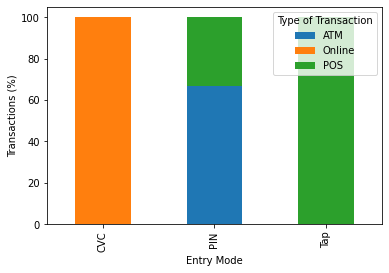

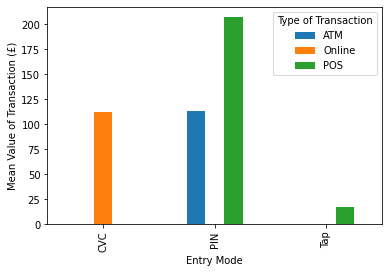

In [157]:
# Look at Type of Transaction vs. Entry Mode to understand inter-dependencies and average spend values for each
ct1 = pd.crosstab(index=df2_train["Entry Mode"], columns=df2_train["Type of Transaction"], values=df2_train.index, aggfunc='count', normalize=True).round(4)*100
ct2 = pd.crosstab(index=df2_train["Entry Mode"], columns=df2_train["Type of Transaction"], values=df2_train["Amount"], aggfunc='mean').round(2)
print("Percentage of transactions: Type of Transaction vs. Entry Mode \n", ct1, '\n\n',
      "Average transaction values: Type of Transactions vs. Entry Mode \n", ct2)

# First chart shows how each Entry Type is split across Type of Transaction 
bar1 = (round(pd.crosstab(index=df2_train["Entry Mode"], columns=df2_train["Type of Transaction"], values=df2_train.index, aggfunc='count', normalize='index'),4)*100).plot(
    kind='bar', stacked=True, xlabel='Entry Mode',ylabel='Transactions (%)')

# Second chart shows mean amount of transactions for entry mode/type of transaction
bar2 = pd.crosstab(index=df2_train["Entry Mode"], columns=df2_train["Type of Transaction"], values=df2_train["Amount"], aggfunc='mean').plot(kind='bar', 
                           xlabel='Entry Mode',ylabel='Mean Value of Transaction (£)')

print(bar1, '\n', bar2);

2.4.1: We can create one variable to explain both Type of Transaction and Entry Mode by combining the two.

In [162]:
# Create new single variable for Entry Mode/Type of Transaction
df2_train["Type Entry"] = df2_train[["Type of Transaction", "Entry Mode"]].apply("-".join, axis=1)
# Create crosstabs to validate output
check_new_var = pd.crosstab(index=df2_train["Type Entry"], columns='Percent', values=df2_train.index, aggfunc='count', normalize=True).round(4)*100
Type_Entry_Fraud = pd.crosstab(index=df2_train["Type Entry"], columns=df2_train["Fraud"], values=df2_train.index, aggfunc='sum', normalize='index').round(4)*100
print("New Type Entry variable: \n", check_new_var,
      "\n\n New Type Entry variable Fraud likelihood: \n", Type_Entry_Fraud)
# Result shows that Fraud rates differ considerably across our new variable

New Type Entry variable: 
 col_0       Percent
Type Entry         
ATM-PIN       33.33
Online-CVC    33.50
POS-PIN       16.70
POS-Tap       16.47 

 New Type Entry variable Fraud likelihood: 
 Fraud           0      1
Type Entry              
ATM-PIN     95.16   4.84
Online-CVC  90.55   9.45
POS-PIN     97.17   2.83
POS-Tap     88.77  11.23


<function matplotlib.pyplot.show>

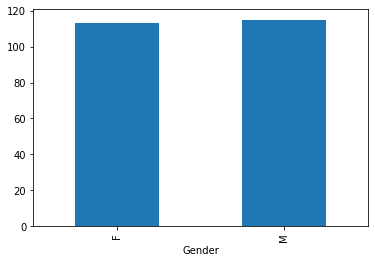

In [189]:
# Understand Age impact on Spend

# Create age bins
df2_train['Age_bins'] = pd.qcut(df2_train['Age'], 10, labels=[1,2,3,4,5,6,7,8,9,10])

# Average spend by Age
age_spend = df2_train.groupby(["Age_bins"])["Amount"].mean().plot(kind='bar')
plt.show
merchant_spend = df2_train.groupby(["Merchant Group"])["Amount"].mean().plot(kind='bar')
plt.show
gender_spend = df2_train.groupby(["Gender"])["Amount"].mean().plot(kind='bar')
#merch_gend_spend = df2_train.groupby(["Merchant Group","Gender"])["Amount"].mean().plot(kind='bar')
plt.show

In [ ]:
# Do males and females spend different amounts by category?
#Use If statement to figure out which is higher and by how much:
zl1_gradm = zl1[(zl1["Graduate"] == 1) & (zl1["Gender"] == 1)] # Male Grads
print("Male Graduates have average income of £",round(zl1_gradm["ApplicantIncome"].mean(),2))
zl1_gradf = zl1[(zl1["Graduate"] == 1) & (zl1["Gender"] == 2)] # Female Grads
print("Female Graduates have average income of £",round(zl1_gradf['ApplicantIncome'].mean(),2))
if zl1_gradm["ApplicantIncome"].mean() > zl1_gradf['ApplicantIncome'].mean():
  print("Male grads have a mean income that is",
        round(zl1_gradm["ApplicantIncome"].mean() / zl1_gradf['ApplicantIncome'].mean()*100-100,0),
        "% higher than Female grads")
elif zl1_gradm["ApplicantIncome"].mean() < zl1_gradf['ApplicantIncome'].mean():
  print("Female grads have a mean income that is",
        round(zl1_gradm["ApplicantIncome"].mean() / zl1_gradf['ApplicantIncome'].mean()*100-100,0),
        "% higher than Male grads")
else:
  print("Female and Male mean incomes are equal")

# Show median/mean
C5 = zl1.groupby(['Graduate','Gender'])['TotalApplicantIncome'].agg(count='size', mean='mean', median='median').round(0)
C5 

Male Graduates have average income of £ 6144.57
Female Graduates have average income of £ 4646.47
Male grads have a mean income that is 32.0 % higher than Female grads


count    mean  median
Graduate Gender                       
0        1         114  5033.0  4880.0
         2          20  5171.0  3984.0
1        1         388  7977.0  5969.0
         2          92  5878.0  4322.0

### 2.2: ENCODE categorical variables
This will support effective correlation analysis. We will scale numeric data later as this won't impact correlations if unscaled.

In [ ]:
# Import libraries 
from sklearn import preprocessing as pp

# Define which columns should be encoded vs scaled
columns_to_encode = df2.select_dtypes(include = object).columns
columns_to_scale  = df2.select_dtypes(include = ['float64','int64'],).columns
print("Columns to encode:", columns_to_encode)
print("Columns to scale:", columns_to_scale)

# Instantiate encoder/scaler
encoder = pp.LabelEncoder()
scaler = pp.MinMaxScaler()

label_encoders = {}
label_scalers = {}  

for column in columns_to_encode:
    label_encoders[column] = encoder
    df2[column] = label_encoders[column].fit_transform(df2[column])

# Here is how to scale the numeric data later on
# df2[columns_to_scale] = scaler.fit_transform(df2[columns_to_scale])
print(df2.head())


Columns to encode: Index(['Date', 'Day of Week', 'Type of Card', 'Entry Mode',
       'Type of Transaction', 'Merchant Group', 'Country of Transaction',
       'Shipping Address', 'Country of Residence', 'Gender', 'Bank'],
      dtype='object')
Columns to scale: Index(['Time', 'Amount', 'Age', 'Fraud'], dtype='object')
   Date  Day of Week  Time  Type of Card  Entry Mode  Amount  \
0     1            1    19             1           2     5.0   
1     1            1    17             0           1   288.0   
2     1            1    14             1           2     5.0   
3     0            0    14             1           2    28.0   
4     0            0    23             1           0    91.0   

   Type of Transaction  Merchant Group  Country of Transaction  \
0                    2               2                       4   
1                    2               8                       3   
2                    2               7                       1   
3                    2        

### 2.3: Explore Correlations
The correlation matrix in the profile report suggests some strong correlations with Fraud marker, we will explore these further as well as correlations between predictor variables

Date                     -0.011667
Day of Week              -0.011667
Time                     -0.286503
Type of Card              0.034728
Entry Mode               -0.007605
Amount                   -0.109980
Type of Transaction       0.030747
Merchant Group           -0.069089
Country of Transaction   -0.307085
Shipping Address         -0.292548
Country of Residence      0.105823
Gender                    0.047569
Age                      -0.002789
Bank                     -0.005186
Fraud                     1.000000
dtype: float64


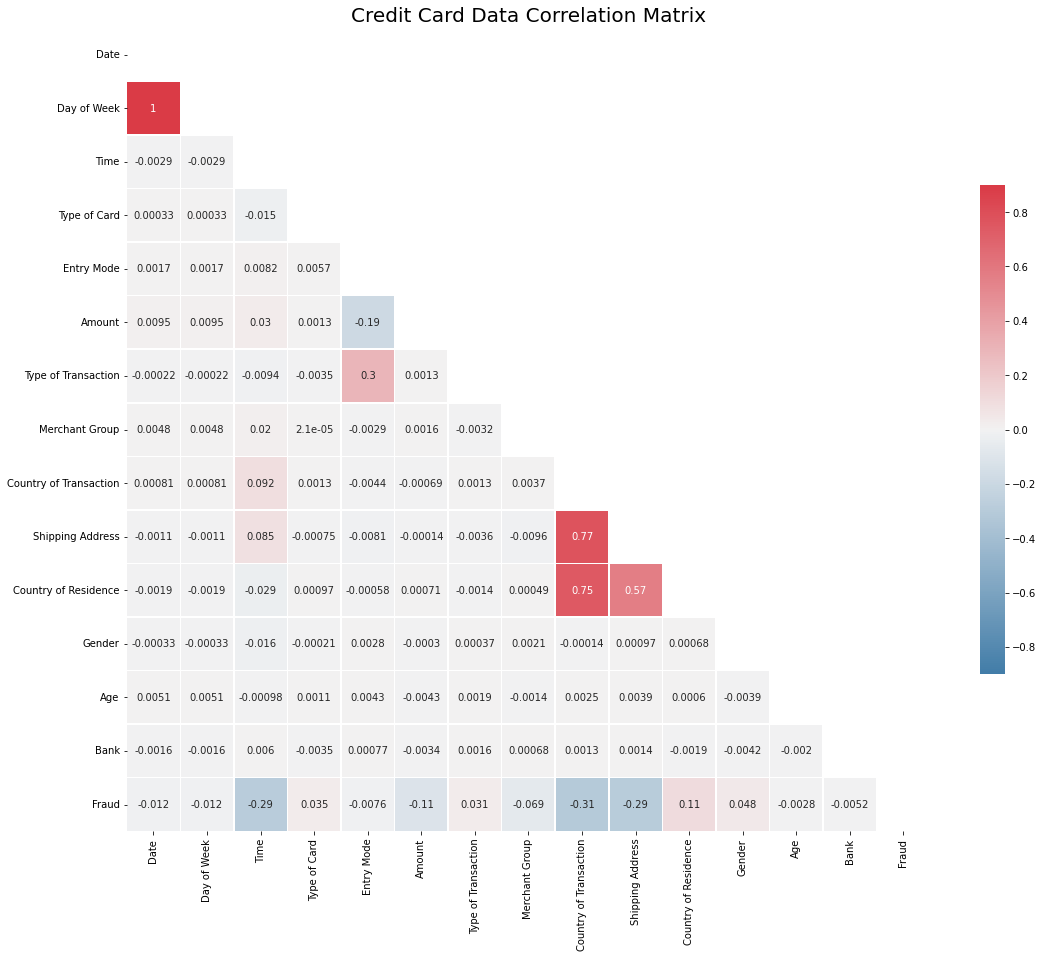

In [ ]:

import seaborn as sns # Import seaborn to create heatmap


correlation1 = df2.corrwith(df2['Fraud'])
print(correlation1)

# Use pandas corr and seaborn to create full correlation matrix and a half-heatmap.
correlation2 = df2.corr()

# Set up the  figure - large to enable values to be shown
f, ax = plt.subplots(figsize=(18, 18))
plt.title('Credit Card Data Correlation Matrix', fontsize = 20) # title with fontsize 20

# Generate a mask for the upper triangle using triu (replacing with ones)
mask = np.triu(np.ones_like(correlation2, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation2, mask=mask, vmin=-0.9, vmax=0.9, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": 0.5})
plt.show()


2.3.1: **Correlations Commentary**

The primary correlations with Fraud are (by order of magnitude):
- Country of Transaction
- Time
- Shipping Address
- Country of Residence
- Amount

There is also some lower-level correlation between Fraud and...
- Merchant Group
- Gender
- Type of Card
- Type of Transaction

There is multicollinearity between:
- Day of Week vs. Date (We would expect this - Drop Day of Week from dataset)
- Amount vs. Entry Mode (We would expect this as some types of entry modes enforce payment limits)
- Type of Transaction vs. Entry Mode (Expected, as Entry Modes have dependency on Type of Transaction)
- Shipping Address vs. Country of Transaction (Expected multicollinearity since most people will have goods delivered to address where they are)
- Country of Residence vs. Shipping Address/Country of Transaction (Again, expected correlation as customer likely to reside in same country as transaction and where goods will be sent)

When creating features, it would be worth combining Type of Transaction/Entry Mode into one variable, and possibly binary features showing where Country of Residence/Shipping Address/Country of Transaction don't match.

There is some collinearity between:
- Time vs. Country of Transaction/Shipping Address (Could purely be a function of timezones in which purchases are made)


**Ethical Considerations**

Based on regulatory framework and the risk of model bias, I would not include Gender in my model at all, as this would risk detrimental transaction experiences based on customer gender - effectively discrimination.

#<font color='Orange'> 3: Create Feature Variables </font>
We have already created the following feature variables (numbers show step in which this was created.

- 1.4.2: TxnID_Dup - flagging where Txn_ID appears more than once in the dataset
- 2.4.1: Type_Entry - concatenating Type of Transaction and Entry Mode

In [ ]:
# Feature creation
loans_clean4 = pd.DataFrame(loans_clean3)

# Total income may impact loan decision for joint applications
loans_clean4['TotalApplicantIncome'] = loans_clean4['ApplicantIncome'] + loans_clean4['CoapplicantIncome']

# Repayment amount to income ratio could indicate whether loan is affordable
loans_clean4['Repayment_v_Income'] = ((loans_clean4['LoanAmount'] / loans_clean4['Loan_Amount_Term']) / loans_clean4['TotalApplicantIncome']) * 100
loans_clean4['Repayment_v_IncomeBins'] = pd.qcut(loans_clean4['Repayment_v_Income'], 4, labels=["Low","Low-Mid","Mid-High","High"])

# Loan to Income ratio could be affordability proxy
loans_clean4['Loan_v_Income'] = (loans_clean4['LoanAmount'] / loans_clean4['TotalApplicantIncome']) * 100
loans_clean4['Loan_v_IncomeBins'] = pd.qcut(loans_clean4['Loan_v_Income'], 4, labels=["Low","Low-Mid","Mid-High","High"])

# Joint Application Flag
loans_clean4['Joint_App'] = np.where(loans_clean4['CoapplicantIncome']>0, 'Yes', 'No')

# Total Applicant Income Bands
loans_clean4['TotalIncomeBins'] = pd.qcut(loans_clean4['TotalApplicantIncome'], 10, labels=[1,2,3,4,5,6,7,8,9,10])

print(loans_clean4.shape)
print(loans_clean4.dtypes)
loans_clean4.head(10)

(614, 19)
Gender                       int64
Married                      int64
Dependents                   int64
Graduate                     int64
Self_Employed                int64
ApplicantIncome            float64
CoapplicantIncome          float64
LoanAmount                   int64
Loan_Amount_Term             int64
Credit_History               int64
Property_Area                int64
Loan_Status                 object
TotalApplicantIncome       float64
Repayment_v_Income         float64
Repayment_v_IncomeBins    category
Loan_v_Income              float64
Loan_v_IncomeBins         category
Joint_App                   object
TotalIncomeBins           category
dtype: object


Gender  Married  ...  Joint_App  TotalIncomeBins
Loan_ID                   ...                            
1002          1        0  ...         No                6
1003          1        1  ...        Yes                7
1005          1        1  ...         No                1
1006          1        1  ...        Yes                5
1008          1        0  ...         No                6
1011          1        1  ...        Yes                9
1013          1        1  ...        Yes                3
1014          1        1  ...        Yes                6
1018          1        1  ...        Yes                6
1020          1        1  ...        Yes               10

[10 rows x 19 columns]

# D: Predictive Analysis

This section uses the SciKitLearn code library, from where we will import useful modules.

### D1: Read in modified dataset, to prepare for model build.

In [ ]:
zl2 = pd.read_csv('Full_Loans_Dataset_3.csv', index_col=['Loan_ID'])
zl2.head()

Gender  Married  ...  TotalIncomeBins  Loan_Status_Int
Loan_ID                   ...                                  
1002          1        0  ...                6                1
1003          1        1  ...                7                0
1005          1        1  ...                1                1
1006          1        1  ...                5                1
1008          1        0  ...                6                1

[5 rows x 20 columns]

### D2: Create target dataset and feature dataset. As there are only two possible outcomes, we will be using binary classification methods to predict the target variable.

The feature dataset are the variables used to predict an outcome. Predictor variables based on brief: Gender, Married, Dependents, Self-Employed, Graduate, Credit_History, Property_Area


In [ ]:
x = zl2.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term',
              'Loan_Status','TotalApplicantIncome','Repayment_v_Income','Repayment_v_IncomeBins',
              'Loan_v_Income','Joint_App','TotalIncomeBins','Loan_Status_Int', 'Loan_v_IncomeBins'], axis=1) # Predictor variables
y = zl2['Loan_Status'] # Target dataset
print(x.shape, y.shape, '\n', x.dtypes, y.dtypes)


(614, 7) (614,) 
 Gender            int64
Married           int64
Dependents        int64
Graduate          int64
Self_Employed     int64
Credit_History    int64
Property_Area     int64
dtype: object object


### D3: Scale data to remove influence of high variance in key columns.

Feature variables don't have high variance, but it makes sense to ensure each variable has an equal chance to feature in a distance-based classifier (e.g. KNearest Neighbour). The Min-Max method gives a value between 0 and 1 for all variables, using the formula below.

$x'=\frac{x-min(x)}{max(x)-min(x)}$

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# define min-max scaler
scaler = MinMaxScaler()
# transform data
xs = scaler.fit_transform(x)
print(xs)

[[0.         0.         0.         ... 0.         1.         0.        ]
 [0.         1.         0.33333333 ... 0.         1.         1.        ]
 [0.         1.         0.         ... 1.         1.         0.        ]
 ...
 [0.         1.         0.33333333 ... 0.         1.         0.        ]
 [0.         1.         0.66666667 ... 0.         1.         0.        ]
 [1.         0.         0.         ... 1.         0.         0.5       ]]


### D4: Split population into test and train datasets.

As the dataset we are working with is small, I tried various population splits (undocumented). The results suggest that a 50/50% split across training and test datasets provides for a good sample to both train and validate the model.




In [ ]:
from sklearn.model_selection import train_test_split

# Create model training and test splits.  Then check shapes
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size = 0.5, random_state = 1) # Random state = 1 ensures results are reproducible through seeding
print("x-train:", x_train.shape)
print("x-test:", x_test.shape)
print("y-train:", y_train.shape)
print("y-test:", y_test.shape)

x-train: (307, 7)
x-test: (307, 7)
y-train: (307,)
y-test: (307,)


### D5: Create classifications using training data, using default settings of 5 models chosen specifically for binary classification from scikit learn library.

In [ ]:
# Import Scikit Learn libraries for the classifications we'll build
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#Fit and predict each model type based on default settings
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_pred = dt.predict(x_test)

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
gb_pred = gb.predict(x_test)

log = LogisticRegression()
log.fit(x_train, y_train)
log_pred = log.predict(x_test)

### D6: Import Classification report to see effectiveness metrics for each classifier vs. test dataset.

* TP = True Positive
* TN = True Negative
* FP = False Positive
* FN = False Negative

While Accuracy is a good measure, approving a loan incorrectly is worse than NOT approving a loan we should have done, due to cost of loan default, so it's important to understand precision and recall. F1 score can analyse as one outcome.

$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$ - For all labelled as approved, how many were actually approved?

$Precision = \frac{TP}{TP+FP}$ - For all loans labelled as approved, how many were actually approved?

$Recall = \frac{TP}{TP+FN}$ - For all approved loans, how many did we label correctly?

$F1 Score = \frac {TP}{TP+\frac{1}{2}(FP+FN)}$ - Weighted average of Precision & Recall


In [ ]:
from sklearn.metrics import classification_report

# Check measures against each model prediction
print("Decision Tree: \n",classification_report(y_test, dt_pred))
print("K-Nearest Neighbour: \n",classification_report(y_test, knn_pred))
print("Random Forest: \n",classification_report(y_test, rf_pred))
print("Gradient Boosting: \n",classification_report(y_test, gb_pred))
print("Logistic Regression: \n",classification_report(y_test, log_pred))

Decision Tree: 
               precision    recall  f1-score   support

           N       0.57      0.39      0.46        98
           Y       0.75      0.86      0.80       209

    accuracy                           0.71       307
   macro avg       0.66      0.62      0.63       307
weighted avg       0.69      0.71      0.69       307

K-Nearest Neighbour: 
               precision    recall  f1-score   support

           N       0.71      0.38      0.49        98
           Y       0.76      0.93      0.84       209

    accuracy                           0.75       307
   macro avg       0.74      0.65      0.66       307
weighted avg       0.75      0.75      0.73       307

Random Forest: 
               precision    recall  f1-score   support

           N       0.67      0.39      0.49        98
           Y       0.76      0.91      0.83       209

    accuracy                           0.74       307
   macro avg       0.71      0.65      0.66       307
weighted avg     

### D7: According to the combined measures, Logistic Regression is strongest at predicting approved and declined loans, and has the best f1 scores.

The confusion matrix shows 187 of 209 approved loans and 48 out of 98 declined loans predicted correctly - our best result from all default models.

Coefficients in the model show the influence that each variable has on the outcome. Credit_History has an overwhelming influence, in line with observations on the correlation plot.

NB: My best model was chosen based on scikit learn default settings, but it's recommended to adjust model settings or feature variables for each type of model to achieve optimal outcomes.



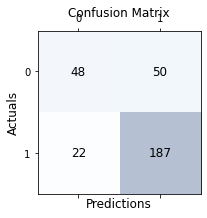

                0  Coefficients
5  Credit_History      1.985997
1         Married      0.431581
0          Gender      0.335669
3        Graduate      0.197545
6   Property_Area      0.112889
4   Self_Employed     -0.081860
2      Dependents     -0.060026


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, log_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

# Create dataframe to show table of coefficients in order of influence
coef_table = pd.DataFrame(list(x.columns)).copy()
coef_table.insert(len(coef_table.columns),'Coefficients',log.coef_.transpose())
print(coef_table.sort_values(by='Coefficients', ascending=False, key=abs))

### D8: Predict outcomes for logistic regression with new data.

Create array of new values to score, predict outcome, then create dataframe with predictions for all models appended.


In [ ]:
new_applicants = {'Gender': [0,1,1,1,0],
                  'Married': [0,1,0,1,1],
                  'Dependents': [0,0.33,0.66,0,1],
                  'Graduate': [1,0,0,1,1],
                  'Self-Employed': [1,0,0,0,1],
                  'Credit_History': [1,0,0,0,1],
                  'Property_Area': [0,0.5,0,1,0.5]
                  }
df_new = pd.DataFrame(new_applicants,columns= ['Gender', 'Married','Dependents','Graduate','Self-Employed','Credit_History','Property_Area'])
log_pred2 = log.predict(df_new)
# We can also see if other models may have predicted differently
dt_pred2 = dt.predict(df_new)
knn_pred2 = knn.predict(df_new)
rf_pred2 = rf.predict(df_new)
gb_pred2 = gb.predict(df_new)

# Append outcomes to dataframe
df_new['log_prediction'] = log_pred2
df_new['dt_prediction'] = dt_pred2
df_new['knn_prediction'] = knn_pred2
df_new['rf_prediction'] = rf_pred2
df_new['gb_prediction'] = gb_pred2
df_new



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature nam

Gender  Married  Dependents  ...  knn_prediction  rf_prediction  gb_prediction
0       0        0        0.00  ...               N              N              Y
1       1        1        0.33  ...               Y              Y              Y
2       1        0        0.66  ...               Y              N              Y
3       1        1        0.00  ...               Y              Y              N
4       0        1        1.00  ...               Y              Y              Y

[5 rows x 12 columns]